# Phase 3: Exploratory Data Analysis (EDA)

## Objective
Uncover the hidden trends and correlations driving readmissions. We will inspect the target variable imbalance, demographic disparities, medication efficacy, and operational metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
df = pd.read_csv('../data/processed/diabetic_data_enriched.csv')

# Display first few rows and columns to verify
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (100114, 52)


C:\Users\Charuka\AppData\Local\Temp\ipykernel_5460\1073403986.py:11: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/diabetic_data_enriched.csv')


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_desc,admission_source_desc,Primary_Diagnosis_Desc
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,NaN,...,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral,Other
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,NaN,...,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room,"Disorders of fluid, electrolyte, and acid-base..."
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,Other
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,NaN,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Other
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,NaN,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Other


## 1. The Readmission Landscape
**Insight**: Identify the class imbalance. Is the <30 group (the HRRP penalty group) a minority?

C:\Users\Charuka\AppData\Local\Temp\ipykernel_5460\707628970.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='readmitted', data=df, order=['NO', '>30', '<30'], palette='viridis')


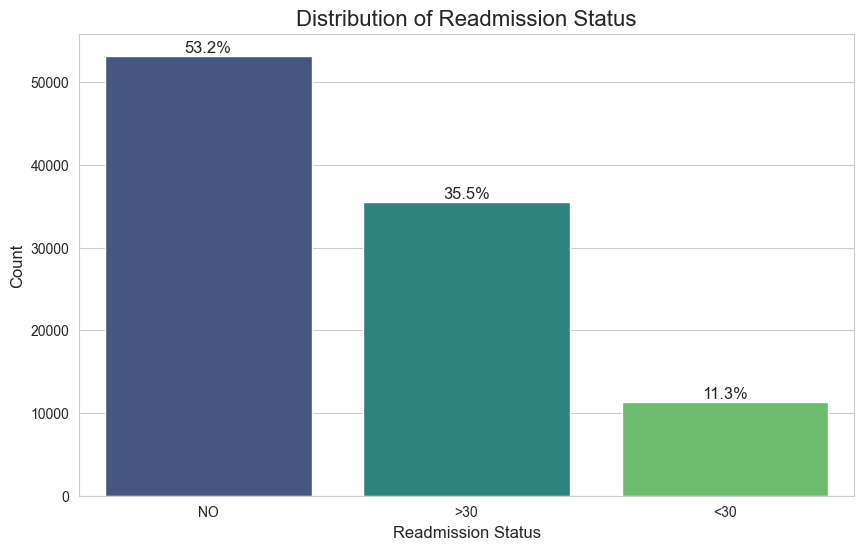

In [2]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='readmitted', data=df, order=['NO', '>30', '<30'], palette='viridis')
plt.title('Distribution of Readmission Status', fontsize=16)
plt.xlabel('Readmission Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add percentage labels
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

## 2. Demographic Profiling
**Goal**: Visualize age distribution and analyze readmission rates by race and gender.

C:\Users\Charuka\AppData\Local\Temp\ipykernel_5460\3543732891.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age', data=df, order=age_order, palette='coolwarm')


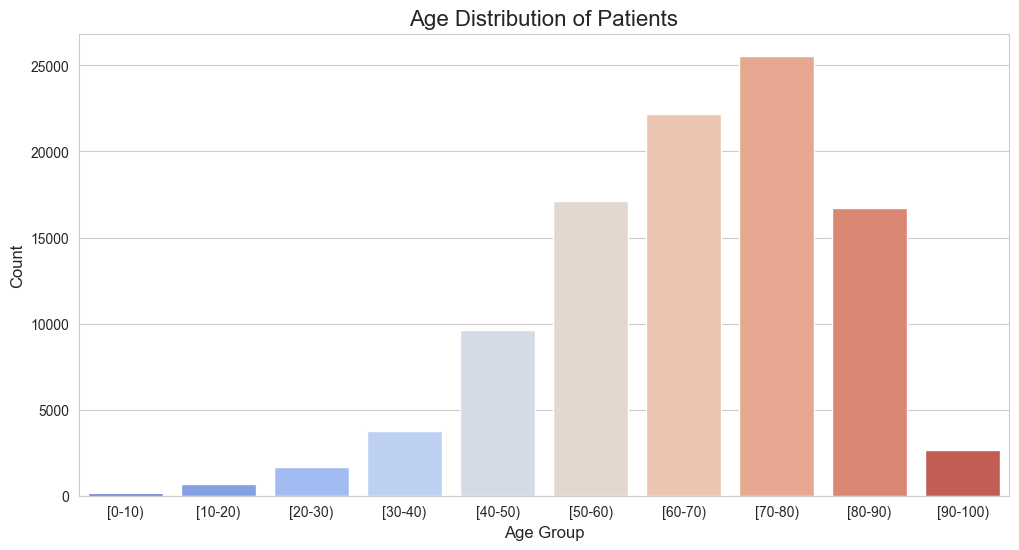

In [3]:
# Age Distribution
plt.figure(figsize=(12, 6))
# Ensure age is treated as a string/categorical if it's binned, verify order
age_order = sorted(df['age'].unique())
sns.countplot(x='age', data=df, order=age_order, palette='coolwarm')
plt.title('Age Distribution of Patients', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

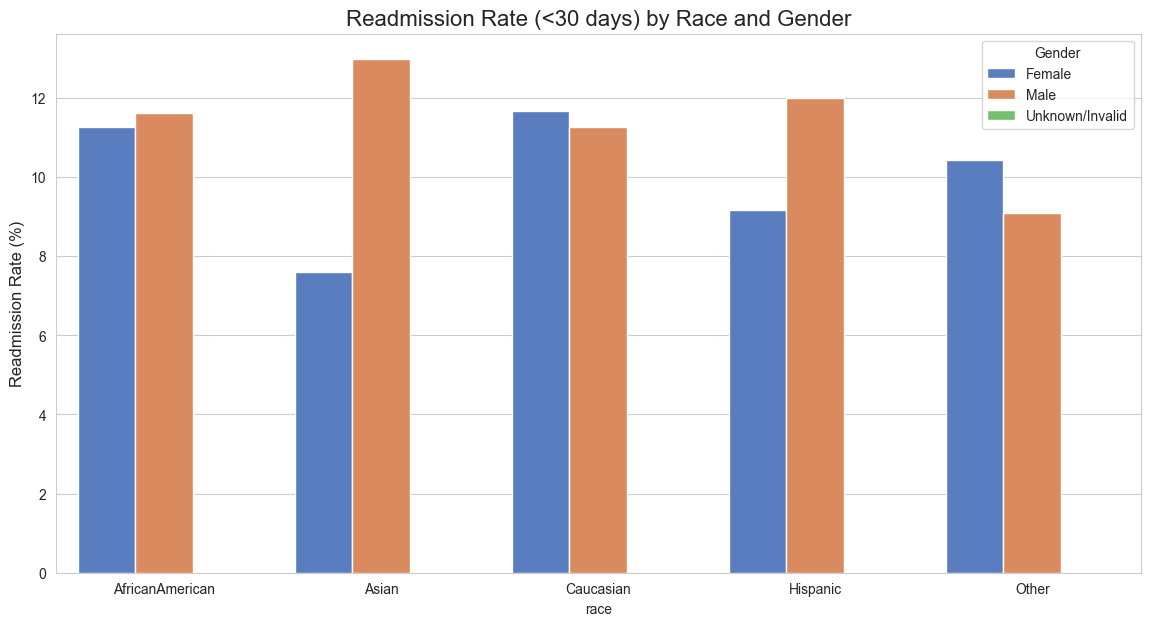

In [4]:
# Readmission rates by Race and Gender
# Helper to calculate rate of '<30' readmission
def calculate_readmission_rate(x):
    return (x == '<30').mean() * 100

race_gender_readm = df.groupby(['race', 'gender'])['readmitted'].apply(calculate_readmission_rate).reset_index()
race_gender_readm.rename(columns={'readmitted': 'Readmission Rate (<30) %'}, inplace=True)

plt.figure(figsize=(14, 7))
sns.barplot(x='race', y='Readmission Rate (<30) %', hue='gender', data=race_gender_readm, palette='muted')
plt.title('Readmission Rate (<30 days) by Race and Gender', fontsize=16)
plt.ylabel('Readmission Rate (%)', fontsize=12)
plt.legend(title='Gender')
plt.show()

## 3. Medication Efficacy Analysis
**Goal**: Compare readmission rates for Insulin vs Oral Meds vs No Meds.
Also check if dosage changes correlate with readmission.

C:\Users\Charuka\AppData\Local\Temp\ipykernel_5460\3382720002.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=med_readm.index, y=med_readm.values, palette='Blues_d')


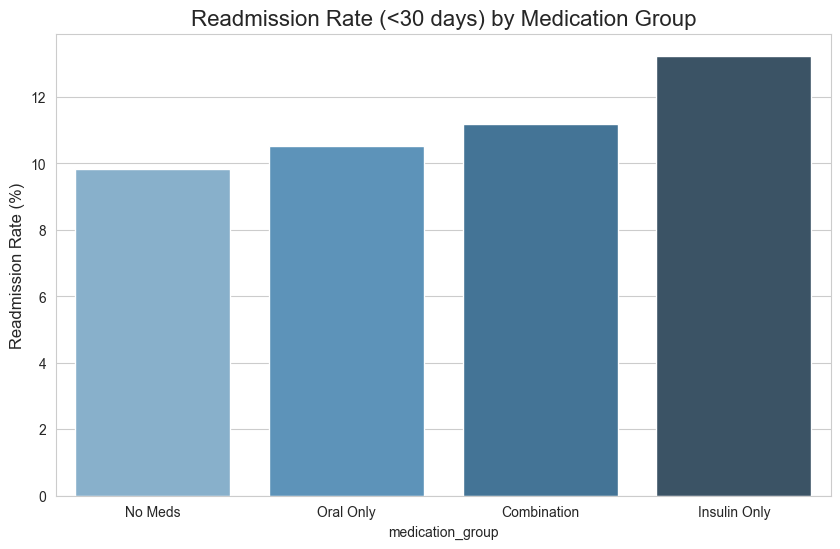

In [5]:
# Identify medication columns
med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
            'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 
            'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
            'tolazamide', 'examide', 'citoglipton', 'insulin', 
            'glyburide-metformin', 'glipizide-metformin', 
            'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

# Check which actually exist in df
existing_med_cols = [c for c in med_cols if c in df.columns]
oral_med_cols = [c for c in existing_med_cols if c != 'insulin']

def classify_meds(row):
    has_insulin = row['insulin'] != 'No'
    has_oral = any(row[col] != 'No' for col in oral_med_cols)
    
    if has_insulin and not has_oral:
        return 'Insulin Only'
    elif has_oral and not has_insulin:
        return 'Oral Only'
    elif has_insulin and has_oral:
        return 'Combination'
    else:
        return 'No Meds'

df['medication_group'] = df.apply(classify_meds, axis=1)

# Visualize Readmission Rate by Med Group
med_readm = df.groupby('medication_group')['readmitted'].apply(calculate_readmission_rate).sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=med_readm.index, y=med_readm.values, palette='Blues_d')
plt.title('Readmission Rate (<30 days) by Medication Group', fontsize=16)
plt.ylabel('Readmission Rate (%)', fontsize=12)
plt.show()

C:\Users\Charuka\AppData\Local\Temp\ipykernel_5460\3903293722.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='change', y='readmitted', data=change_readm, palette='Set2')


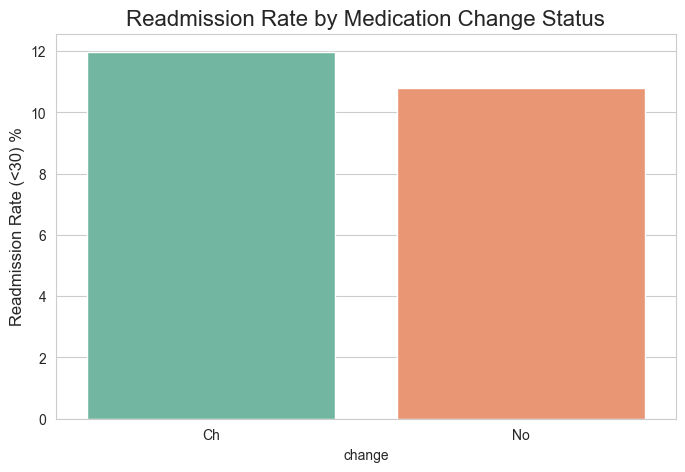

In [6]:
# Analysis of 'change' column
plt.figure(figsize=(8, 5))
# Calculate rates
change_readm = df.groupby('change')['readmitted'].apply(calculate_readmission_rate).reset_index()
sns.barplot(x='change', y='readmitted', data=change_readm, palette='Set2')
plt.title('Readmission Rate by Medication Change Status', fontsize=16)
plt.ylabel('Readmission Rate (<30) %', fontsize=12)
plt.show()

## 4. Operational Metrics
**Goal**: Analyze time in hospital, lab procedures, and discharge disposition.

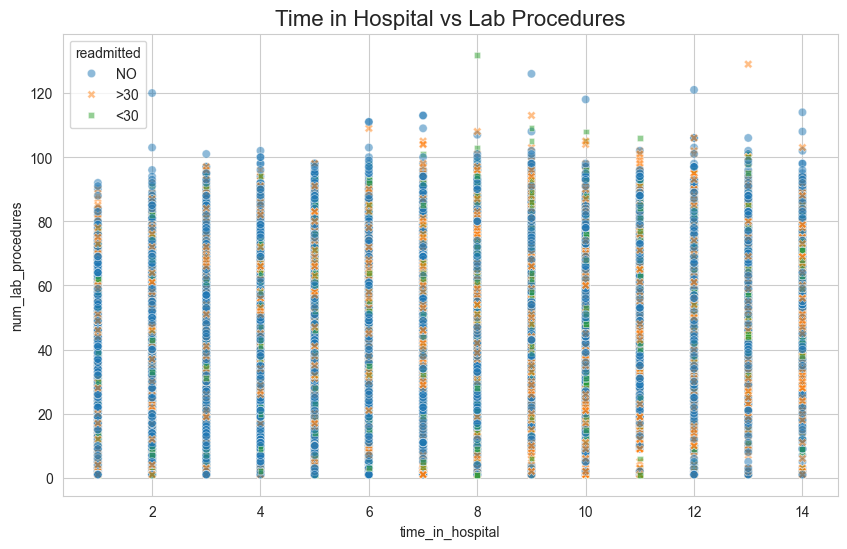

In [7]:
# Relationship between time_in_hospital and num_lab_procedures
plt.figure(figsize=(10, 6))
sns.scatterplot(x='time_in_hospital', y='num_lab_procedures', hue='readmitted', data=df, alpha=0.5, style='readmitted')
plt.title('Time in Hospital vs Lab Procedures', fontsize=16)
plt.show()

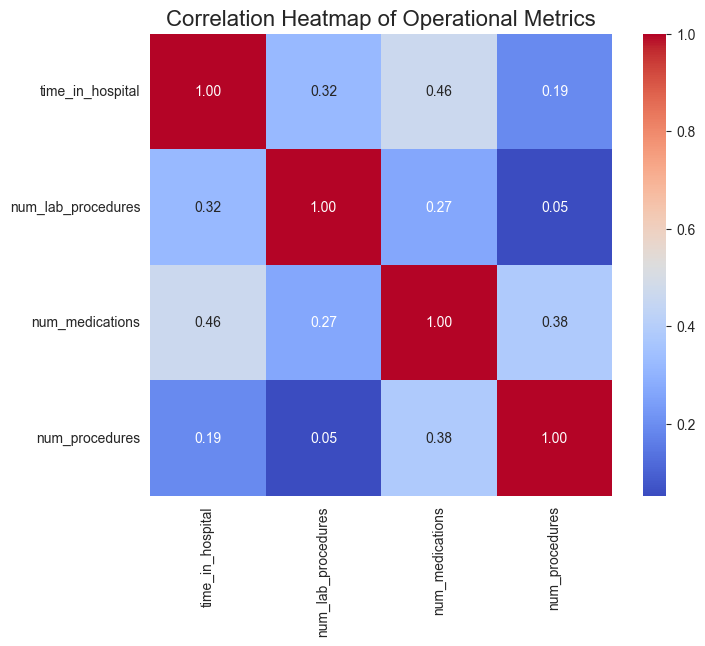

In [8]:
# Correlation Heatmap
cols_to_corr = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 'num_procedures']
corr_matrix = df[cols_to_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Operational Metrics', fontsize=16)
plt.show()

C:\Users\Charuka\AppData\Local\Temp\ipykernel_5460\2256906818.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y='time_in_hospital', data=df, order=['NO', '>30', '<30'], palette='Pastel1')


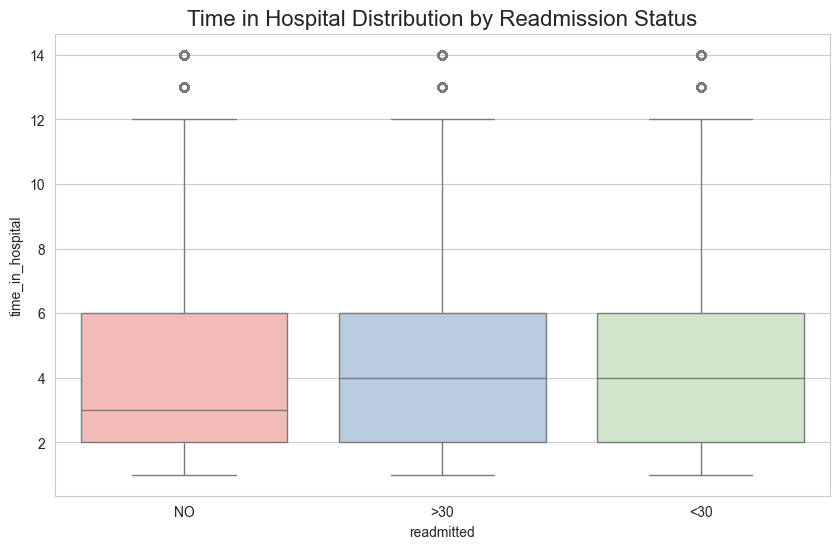

In [9]:
# Box plots of time_in_hospital by readmitted status
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='time_in_hospital', data=df, order=['NO', '>30', '<30'], palette='Pastel1')
plt.title('Time in Hospital Distribution by Readmission Status', fontsize=16)
plt.show()

C:\Users\Charuka\AppData\Local\Temp\ipykernel_5460\1775945624.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dis_readm.index, y=dis_readm.values, palette='rocket')


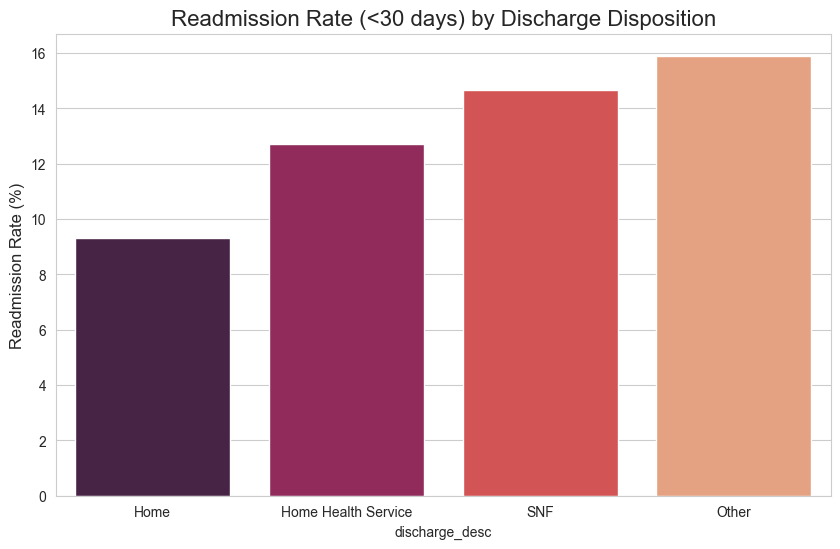

In [10]:
# Discharge Disposition Analysis
# Mapping IDs for clarity
discharge_mapping = {
    1: 'Home',
    3: 'SNF',  # Skilled Nursing Facility
    6: 'Home Health Service',
    # Add others if relevant or frequent
}

# Create a readable column (filling others with ID)
df['discharge_desc'] = df['discharge_disposition_id'].map(discharge_mapping).fillna('Other')

# Filter for top categories to avoid clutter
top_discharges = df['discharge_desc'].value_counts().head(5).index
df_discharge = df[df['discharge_desc'].isin(top_discharges)]

dis_readm = df_discharge.groupby('discharge_desc')['readmitted'].apply(calculate_readmission_rate).sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=dis_readm.index, y=dis_readm.values, palette='rocket')
plt.title('Readmission Rate (<30 days) by Discharge Disposition', fontsize=16)
plt.ylabel('Readmission Rate (%)', fontsize=12)
plt.show()